## Prepare GPP from VODCA2GPP

In this notebook, 8-daily VODCA2 GPP data from 1988 - 1999 is prepared. The following steps are included:
- Crop data to Germany
- Crop to forest area
- Save datasets for needleleaved and broadleaved forests

In [1]:
# import libraries
import os
import xarray as xr
import geopandas as gpd
import odc.stac
import rasterio
import pandas as pd
import warnings
import numpy as np

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# read GPP data
gpp_full = xr.open_dataset("./Raw/VODCA2GPP_v1.nc", decode_coords="all", decode_times=True)

In [5]:
gpp_full

<xarray.Dataset> Size: 12GB
Dimensions:        (lon: 1440, lat: 720, time: 1480)
Coordinates:
  * lon            (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * lat            (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time           (time) datetime64[ns] 12kB 1988-02-02 ... 2020-06-25
    crs            |S1 1B ...
Data variables:
    gpi            (lat, lon) float32 4MB ...
    GPP            (time, lat, lon) float64 12GB ...
    Uncertainties  (lat, lon) float32 4MB ...
Attributes: (12/20)
    title:                    VODCA-based GPP estimate at 8-daily, 0.25 degre...
    geospatial_lon_min:       -179.875
    geospatial_lat_max:       89.875
    data_input:               VODCA (merged-frequency), 8-daily, 0.25deg
    created_with_software:    Python 2.7.11
    geospatial_lon_sampling:  0.25 degree
    ...                       ...
    training_data:            FLUXNET2015
    source:                   GAM_FLUXNET_VOD_dVOD_median_T2M
    date_created:             2021-05-11 07:09:43
    creater_url:              climers.geo.tuwien.ac.at
    geospatial_lon_max:       179.875
    Conventions:              CF-1.6

In [6]:
# look at variable attributes to get more information
gpp_full.gpi.attrs

{'long_name': 'grid point index', 'units': '1'}

In [7]:
gpp_full.GPP.attrs

{'units': 'g C m-2 d-1', 'long_name': 'VODCA-based GPP estimate'}

In [8]:
gpp_full.Uncertainties.attrs

{'units': 'kg C m-2 y-1',
 'long_name': 'Standard deviation derived from the 10-fold leave-station-out uncertainty analysis'}

In [9]:
# roughly limit gpp to research area to speed up computing
gpp_full = gpp_full.sel(lon=slice(5.45, 15.2),
                        lat=slice(47, 55.2))

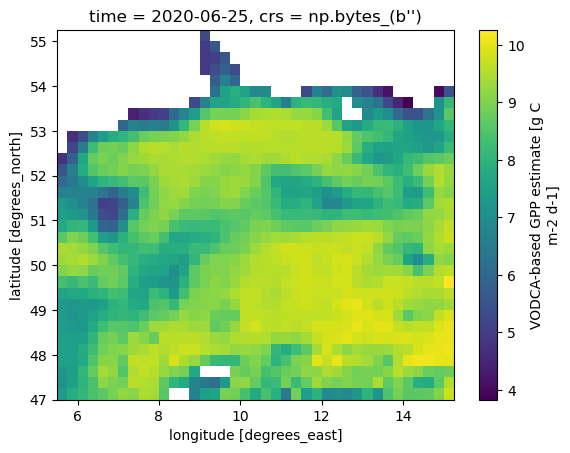

In [10]:
# plot exemplary GPP data of one date to get a first impression
gpp_full.GPP.sel(time = "2020-06-25", method = "nearest").plot()

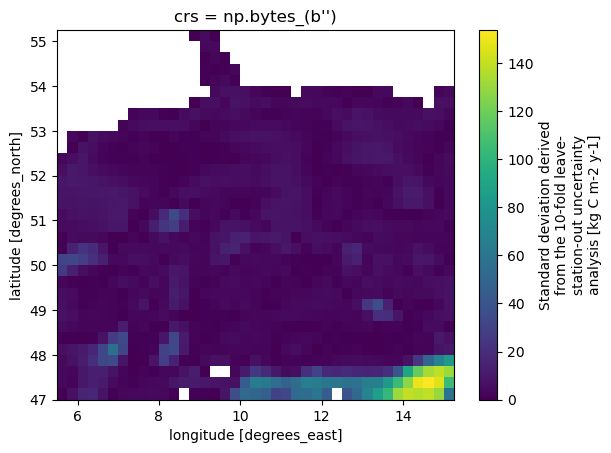

In [11]:
# also look at uncertainties variable
gpp_full.Uncertainties.plot()

In [12]:
# check crs
gpp_full.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [13]:
# load Germany shapefile 
ger = gpd.read_file("./GER.shp")

In [14]:
# check if crs matches data
ger.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
# extract one date to create mask of germany with dimensions of gpp data
gpp_ex = gpp_full.sel(time = "2020-06-25", method = "nearest")

In [16]:
# create mask of research area using the dimensions of the exemplary gpp data
ger_mask = rasterio.features.geometry_mask(ger.geometry, 
                                            out_shape=gpp_ex.odc.geobox.shape,
                                            transform=gpp_ex.odc.geobox.affine,
                                            all_touched=False,
                                            invert=False)

In [17]:
ger_mask = xr.DataArray(ger_mask, dims=("lat", "lon"))

In [18]:
# get all dates that are stored in large gpp dataset
dates = list(gpp_full.time.values)

In [19]:
# loop over dates to process each date seperately
# dataset is too large to be processed at once

for d in dates:
    
    # extract data of this date as xarray
    gpp = gpp_full.sel(time = d)

    # manually get time back as dimension, not just variable
    # time dimension was dropped when selecting
    gpp = gpp.expand_dims('time')

    # apply mask of research area to dataset and extract GPP values
    gpp_ger = gpp["GPP"].where(~ger_mask)

    # load forest area from ESA Landcover data for corresponding year
    # attention: forest data only available for 1992 - 2022 -> choose 1992 for gpp data of 1988-1992
    year = int(str(d)[0:4])

    if year <= 1992:
        forest_year = 1992
    else: forest_year = year

    forest = xr.open_dataset(f"./Forest_GER/Forest_GER_{forest_year}.nc", 
                                decode_coords = "all", 
                                decode_times= True)

    # set crs for gpp data 
    gpp_ger.rio.write_crs(4326, inplace = True)

    # set spatial dims - otherwise resampling raises an error
    gpp_ger.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace = True)

    # resample gpp dataset to match resolution of forest dataset
    gpp_match = gpp_ger.rio.reproject_match(forest)

    # rename dimensions - they got renamed while resampling
    gpp_match = gpp_match.rename({'y':'lat', 'x':'lon'})

    # mask gpp with forest data
    # broadleaved forest:
    gpp_BL = gpp_match.where(forest.lccs_class.sel(time=f"{forest_year}-01-01") == 60, 
                                drop = False)

    # needleleaved forest:
    NL_mask = forest.lccs_class.sel(time=f"{forest_year}-01-01").isin([70, 80]).compute()
    gpp_NL = gpp_match.where(NL_mask, drop = False)

    # compress data to reduce size
    comp = dict(zlib=True, complevel=4)
    gpp_BL.encoding.update(comp)
    gpp_NL.encoding.update(comp)

    # save as netCDF4 datasets
    date = gpp_match.coords["time"].dt.strftime('%Y-%m-%d').values[0]
    gpp_BL.to_netcdf(f"./GPP/GPP_VODCA2/8Daily/{year}/GPP_{date}_BL.nc")
    gpp_NL.to_netcdf(f"./GPP/GPP_VODCA2/8Daily/{year}/GPP_{date}_NL.nc")

In [20]:
# load one processed dataset as example and plot to get an overview
gpp_NL = xr.open_dataarray("./GPP/GPP_VODCA2/8Daily/2020/GPP_2020-06-25_NL.nc", decode_coords = "all", decode_times= True)
gpp_NL

<xarray.DataArray 'GPP' (time: 1, lat: 2952, lon: 3510)> Size: 83MB
[10361520 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 8B 2020-06-25
    crs          |S1 1B ...
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
Attributes:
    units:      g C m-2 d-1
    long_name:  VODCA-based GPP estimate

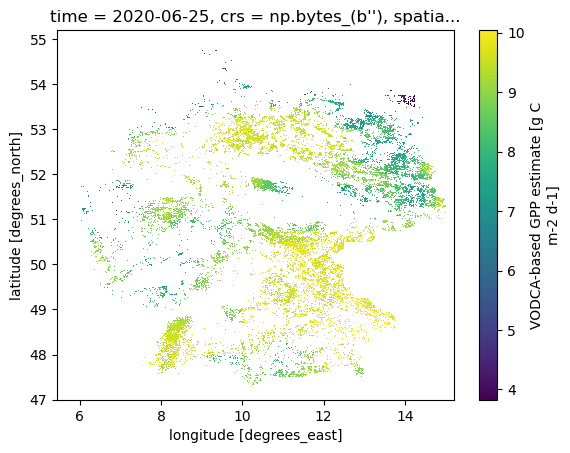

In [21]:
gpp_NL.plot()